# Clustering

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Caricamento del dataset
df = pd.read_csv('Datasets/atp_tennis.csv')

# Pre-elaborazione
# Rimuovere righe con valori mancanti (se presenti)
df = df.dropna()

Prima di eseguire il clustering, dobbiamo raccogliere le feature dai dati delle partite di tennis, seguendo i seguenti passaggi:

1.	Durata della partita:

    Anche se il tuo dataset non include un campo che indichi la durata della partita, possiamo calcolare una metrica equivalente. Possiamo utilizzare il numero di set giocati o la differenza nei punteggi come indicatore della durata della partita.

2.	Numero di partite giocate (total_games_played):

    Calcoliamo il numero di partite giocate per ogni giocatore. Questo si può ottenere contando il numero di righe in cui il giocatore compare come Player_1 o Player_2 nel dataset.

3.	Punteggi totali (total_points):

    Sommiamo i punteggi di un giocatore da ogni partita. Per esempio, possiamo sommare Pts_1 per il giocatore Player_1 e Pts_2 per Player_2 per ottenere un totale di punti per ogni giocatore.

4.	Numero di tornei a cui un giocatore ha partecipato (n_tournaments):

    Questo può essere calcolato contando i tornei distinti a cui un giocatore ha partecipato. Ad esempio, possiamo ottenere il numero di tornei unici tramite il campo Tournament.

5.	Numero di finali giocate (total_final_matches):

    Per calcolare questo, possiamo filtrare le partite in cui un giocatore ha partecipato alla finale (questo potrebbe richiedere una colonna aggiuntiva per identificare la fase del torneo).

6.	Numero di vittorie (total_wins):

    Il numero di vittorie totali di un giocatore può essere calcolato contando il numero di volte che un giocatore appare come Winner nel dataset.

7.	Superficie di gioco (surface):

    Può essere utile come feature categorica, come nel caso dei calciatori con le superfici di gioco (Hard, Grass, Clay), che può influire sul gioco di un tennista.

In [69]:
# 1. Calcolare il numero di partite giocate per ogni giocatore
total_games_player_1 = df.groupby('Player_1').size()
total_games_player_2 = df.groupby('Player_2').size()

# Uniamo i due gruppi per ottenere il numero totale di partite giocate per ogni giocatore
total_games = total_games_player_1.add(total_games_player_2, fill_value=0)

# 2. Calcolare le vittorie per superficie per ogni giocatore
surface_wins = df.groupby(['Winner', 'Surface']).size().unstack(fill_value=0)

# Sommiamo i punteggi per ottenere il totale di punti
#total_points = total_points_player_1.add(total_points_player_2, fill_value=0)

# 3. Calcolare il numero di tornei per ogni giocatore
tournaments_player_1 = df.groupby('Player_1')['Tournament'].nunique()
tournaments_player_2 = df.groupby('Player_2')['Tournament'].nunique()
total_tournaments = tournaments_player_1.add(tournaments_player_2, fill_value=0)

# 4. Calcolare il numero di finali giocate
finals_player_1 = df[df['Round'] == 'The Final'].groupby('Player_1').size()
finals_player_2 = df[df['Round'] == 'The Final'].groupby('Player_2').size()
total_finals = finals_player_1.add(finals_player_2, fill_value=0)

# 5. Numero di vittorie (ogni volta che un giocatore appare come Winner)
total_wins = df.groupby('Winner').size()

# 6. Calcolare il miglior ranking raggiunto
best_rank_1 = df.groupby('Player_1')['Rank_1'].min()
best_rank_2 = df.groupby('Player_2')['Rank_2'].min()
best_rank = best_rank_1.combine_first(best_rank_2)

# Creare il DataFrame finale con tutte le statistiche
player_stats = pd.DataFrame({
    'total_matches': total_games,
    'total_tournaments': total_tournaments,
    'total_finals': total_finals,
    'total_wins': total_wins,
    'best_rank': best_rank
})

# Aggiungere le colonne per le vittorie su ogni superficie
for surface in surface_wins.columns:
    player_stats[f'wins_{surface.lower()}'] = surface_wins[surface]

# 7. Gestire i valori NaN e Inf
# Pulizia dei dati
player_stats = player_stats.fillna(0)
player_stats = player_stats.replace([np.inf, -np.inf], 0)

# Salvare il DataFrame in un file CSV
player_stats.to_csv('Datasets/tennis_player_stats_for_clustering.csv')

# Per verificare che il DataFrame sia stato salvato correttamente
print("\nDimensioni del DataFrame salvato:", player_stats.shape)
print("\nPrime righe del DataFrame:")
print(player_stats.head())

# Mostrare i top 10 giocatori per numero di vittorie
print("Top 10 giocatori per numero di vittorie:")
print(player_stats.sort_values('total_wins', ascending=False).head(10))


Dimensioni del DataFrame salvato: (1358, 8)

Prime righe del DataFrame:
               total_matches  total_tournaments  total_finals  total_wins  \
 Hajek J.                2.0                1.0           0.0         1.0   
Acasuso J.             192.0               68.0           5.0       101.0   
Adaktusson J.            1.0                1.0           0.0         0.0   
Agamenone F.             5.0                2.0           0.0         3.0   
Agassi A.               37.0               17.0           3.0        26.0   

               best_rank  wins_clay  wins_grass  wins_hard  
 Hajek J.           79.0        1.0         0.0        0.0  
Acasuso J.          20.0       67.0         0.0       34.0  
Adaktusson J.      265.0        0.0         0.0        0.0  
Agamenone F.       156.0        3.0         0.0        0.0  
Agassi A.            6.0        0.0         2.0       24.0  
Top 10 giocatori per numero di vittorie:
             total_matches  total_tournaments  total_fina

Filtriamo i tennisti che hanno vinto almeno una volta in carriera

In [70]:
# Calcolare il numero di tennisti con almeno una vittoria
vincitori = player_stats[player_stats['total_wins'] > 0]
non_vincitori = player_stats[player_stats['total_wins'] == 0]

print(f"Numero di tennisti che hanno vinto almeno una volta: {len(vincitori)}")
print(f"Numero di tennisti che non hanno mai vinto: {len(non_vincitori)}")

# Mostrare la percentuale
totale_tennisti = len(player_stats)
percentuale_vincitori = (len(vincitori) / totale_tennisti) * 100
percentuale_non_vincitori = (len(non_vincitori) / totale_tennisti) * 100

print(f"\nPercentuale vincitori: {percentuale_vincitori:.2f}%")
print(f"Percentuale non vincitori: {percentuale_non_vincitori:.2f}%")

Numero di tennisti che hanno vinto almeno una volta: 901
Numero di tennisti che non hanno mai vinto: 457

Percentuale vincitori: 66.35%
Percentuale non vincitori: 33.65%


In [71]:
# Filtrare i tennisti che hanno vinto almeno una volta in carriera
vincitori = player_stats[player_stats['total_wins'] > 0].sort_values('total_wins', ascending=False)

print("Statistiche dei tennisti con almeno una vittoria:")
print(vincitori)

# Statistiche aggiuntive sui vincitori
print(f"\nNumero totale di vincitori: {len(vincitori)}")
print("\nStatistiche riassuntive delle vittorie:")
print(vincitori['total_wins'].describe())

Statistiche dei tennisti con almeno una vittoria:
                    total_matches  total_tournaments  total_finals  \
Djokovic N.                1201.0               98.0         136.0   
Nadal R.                   1096.0              100.0         119.0   
Federer R.                  979.0               73.0         115.0   
Murray A.                   917.0              138.0          67.0   
Ferrer D.                   874.0              140.0          48.0   
...                           ...                ...           ...   
Matsukevitch D.               4.0                4.0           0.0   
Matsui T.                     3.0                3.0           0.0   
Masur D.                      6.0                5.0           0.0   
Mamiit C.                     3.0                2.0           0.0   
van Scheppingen D.            2.0                2.0           0.0   

                    total_wins  best_rank  wins_clay  wins_grass  wins_hard  
Djokovic N.             1016.0 

## Visualizzazione dei dati tramite distribuzioni e grafici

### Come sono distribuite le vittorie tra i giocatori?

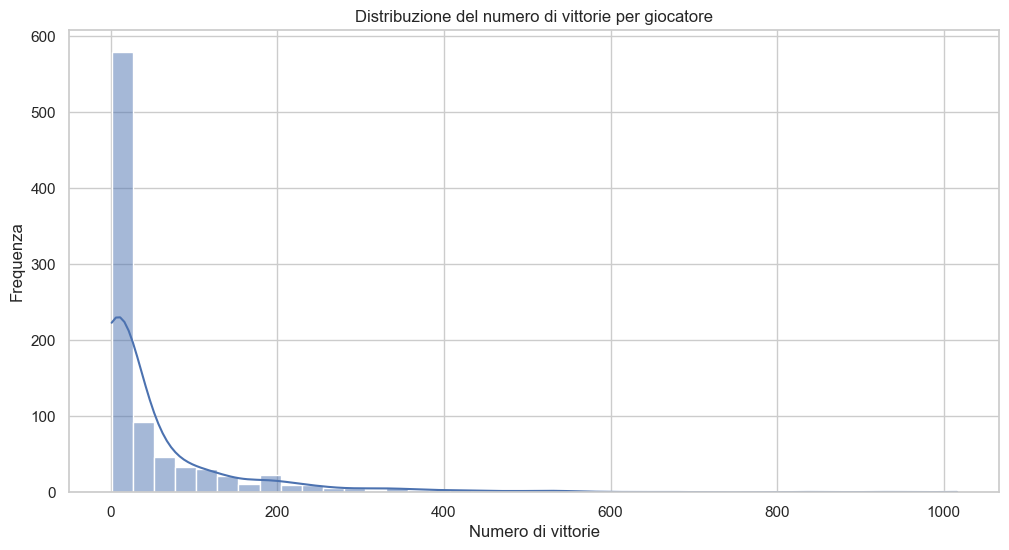

In [72]:
# 1. Distribuzione del numero di vittorie
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.histplot(data=vincitori['total_wins'], kde=True, bins=40)
plt.title('Distribuzione del numero di vittorie per giocatore')
plt.xlabel('Numero di vittorie')
plt.ylabel('Frequenza')
plt.show()

### La relazione tra ranking e vittorie

<Figure size 1800x1200 with 0 Axes>

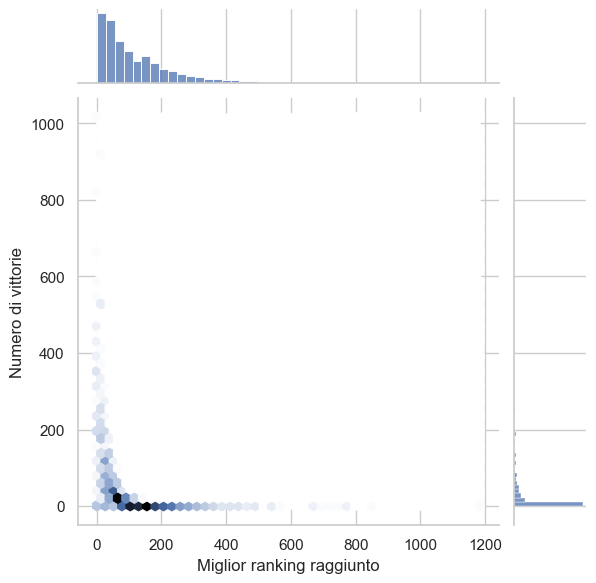

In [73]:
# 2. Relazione tra vittorie e ranking migliore
plt.figure(figsize=(18, 12))
sns.set_style('whitegrid')
sns.jointplot(data=vincitori, x='best_rank', y='total_wins', kind='hex')
plt.xlabel('Miglior ranking raggiunto')
plt.ylabel('Numero di vittorie')
plt.show()

### Come si distribuiscono le vittorie sulle diverse superfici

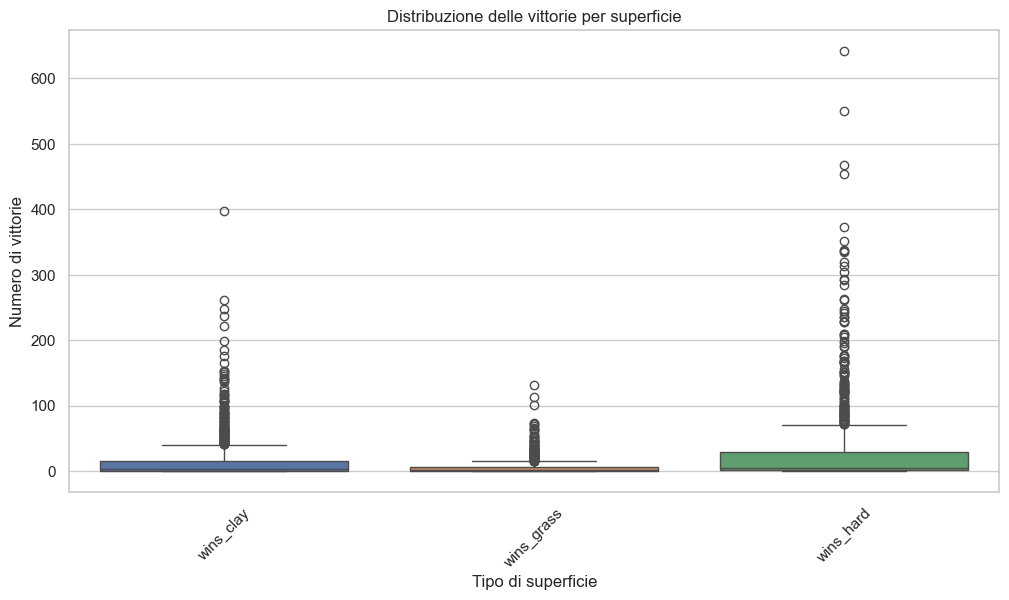

In [74]:
# 3. Distribuzione delle vittorie per superficie
surface_columns = [col for col in vincitori.columns if col.startswith('wins_')]
surface_data = vincitori[surface_columns]

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.boxplot(data=surface_data)
plt.title('Distribuzione delle vittorie per superficie')
plt.xlabel('Tipo di superficie')
plt.ylabel('Numero di vittorie')
plt.xticks(rotation=45)
plt.show()

### Chi sono i giocatori più attivi?


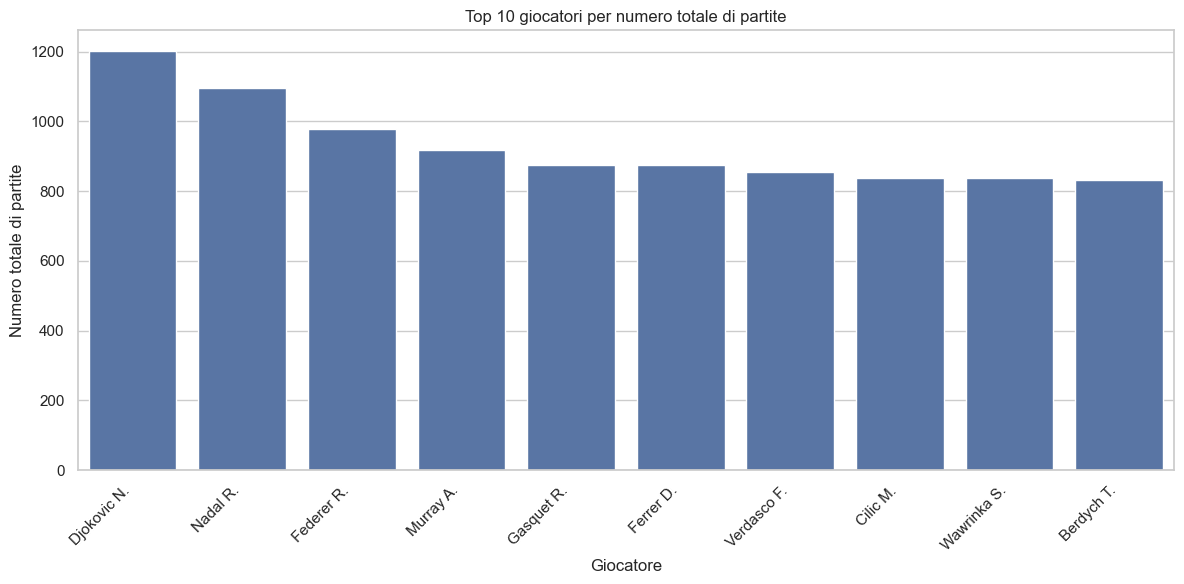

In [75]:
# 4. Top 10 giocatori per numero totale di partite
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
top_10_matches = vincitori.nlargest(10, 'total_matches')
sns.barplot(data=top_10_matches, x=top_10_matches.index, y='total_matches')
plt.title('Top 10 giocatori per numero totale di partite')
plt.xlabel('Giocatore')
plt.ylabel('Numero totale di partite')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Come sono correlate le diverse statistiche tra loro?

La matrice di correlazione è uno strumento molto utile per capire come le variabili del tuo dataset siano collegate tra loro. Essa mostra quanto due variabili siano correlate tra loro: se il valore della correlazione è vicino a 1, significa che c’è una forte correlazione positiva, se è vicino a -1, c’è una forte correlazione negativa, mentre un valore vicino a 0 indica che non c’è correlazione.

Passaggi per calcolare e visualizzare la matrice di correlazione:

1.	Calcolare la matrice di correlazione: Usiamo la funzione .corr() di Pandas, che calcola la correlazione tra le variabili numeriche nel DataFrame.
    
2.	Visualizzare la matrice di correlazione: Usiamo una heatmap per visualizzare la matrice, che rende più facile interpretare i valori di correlazione.

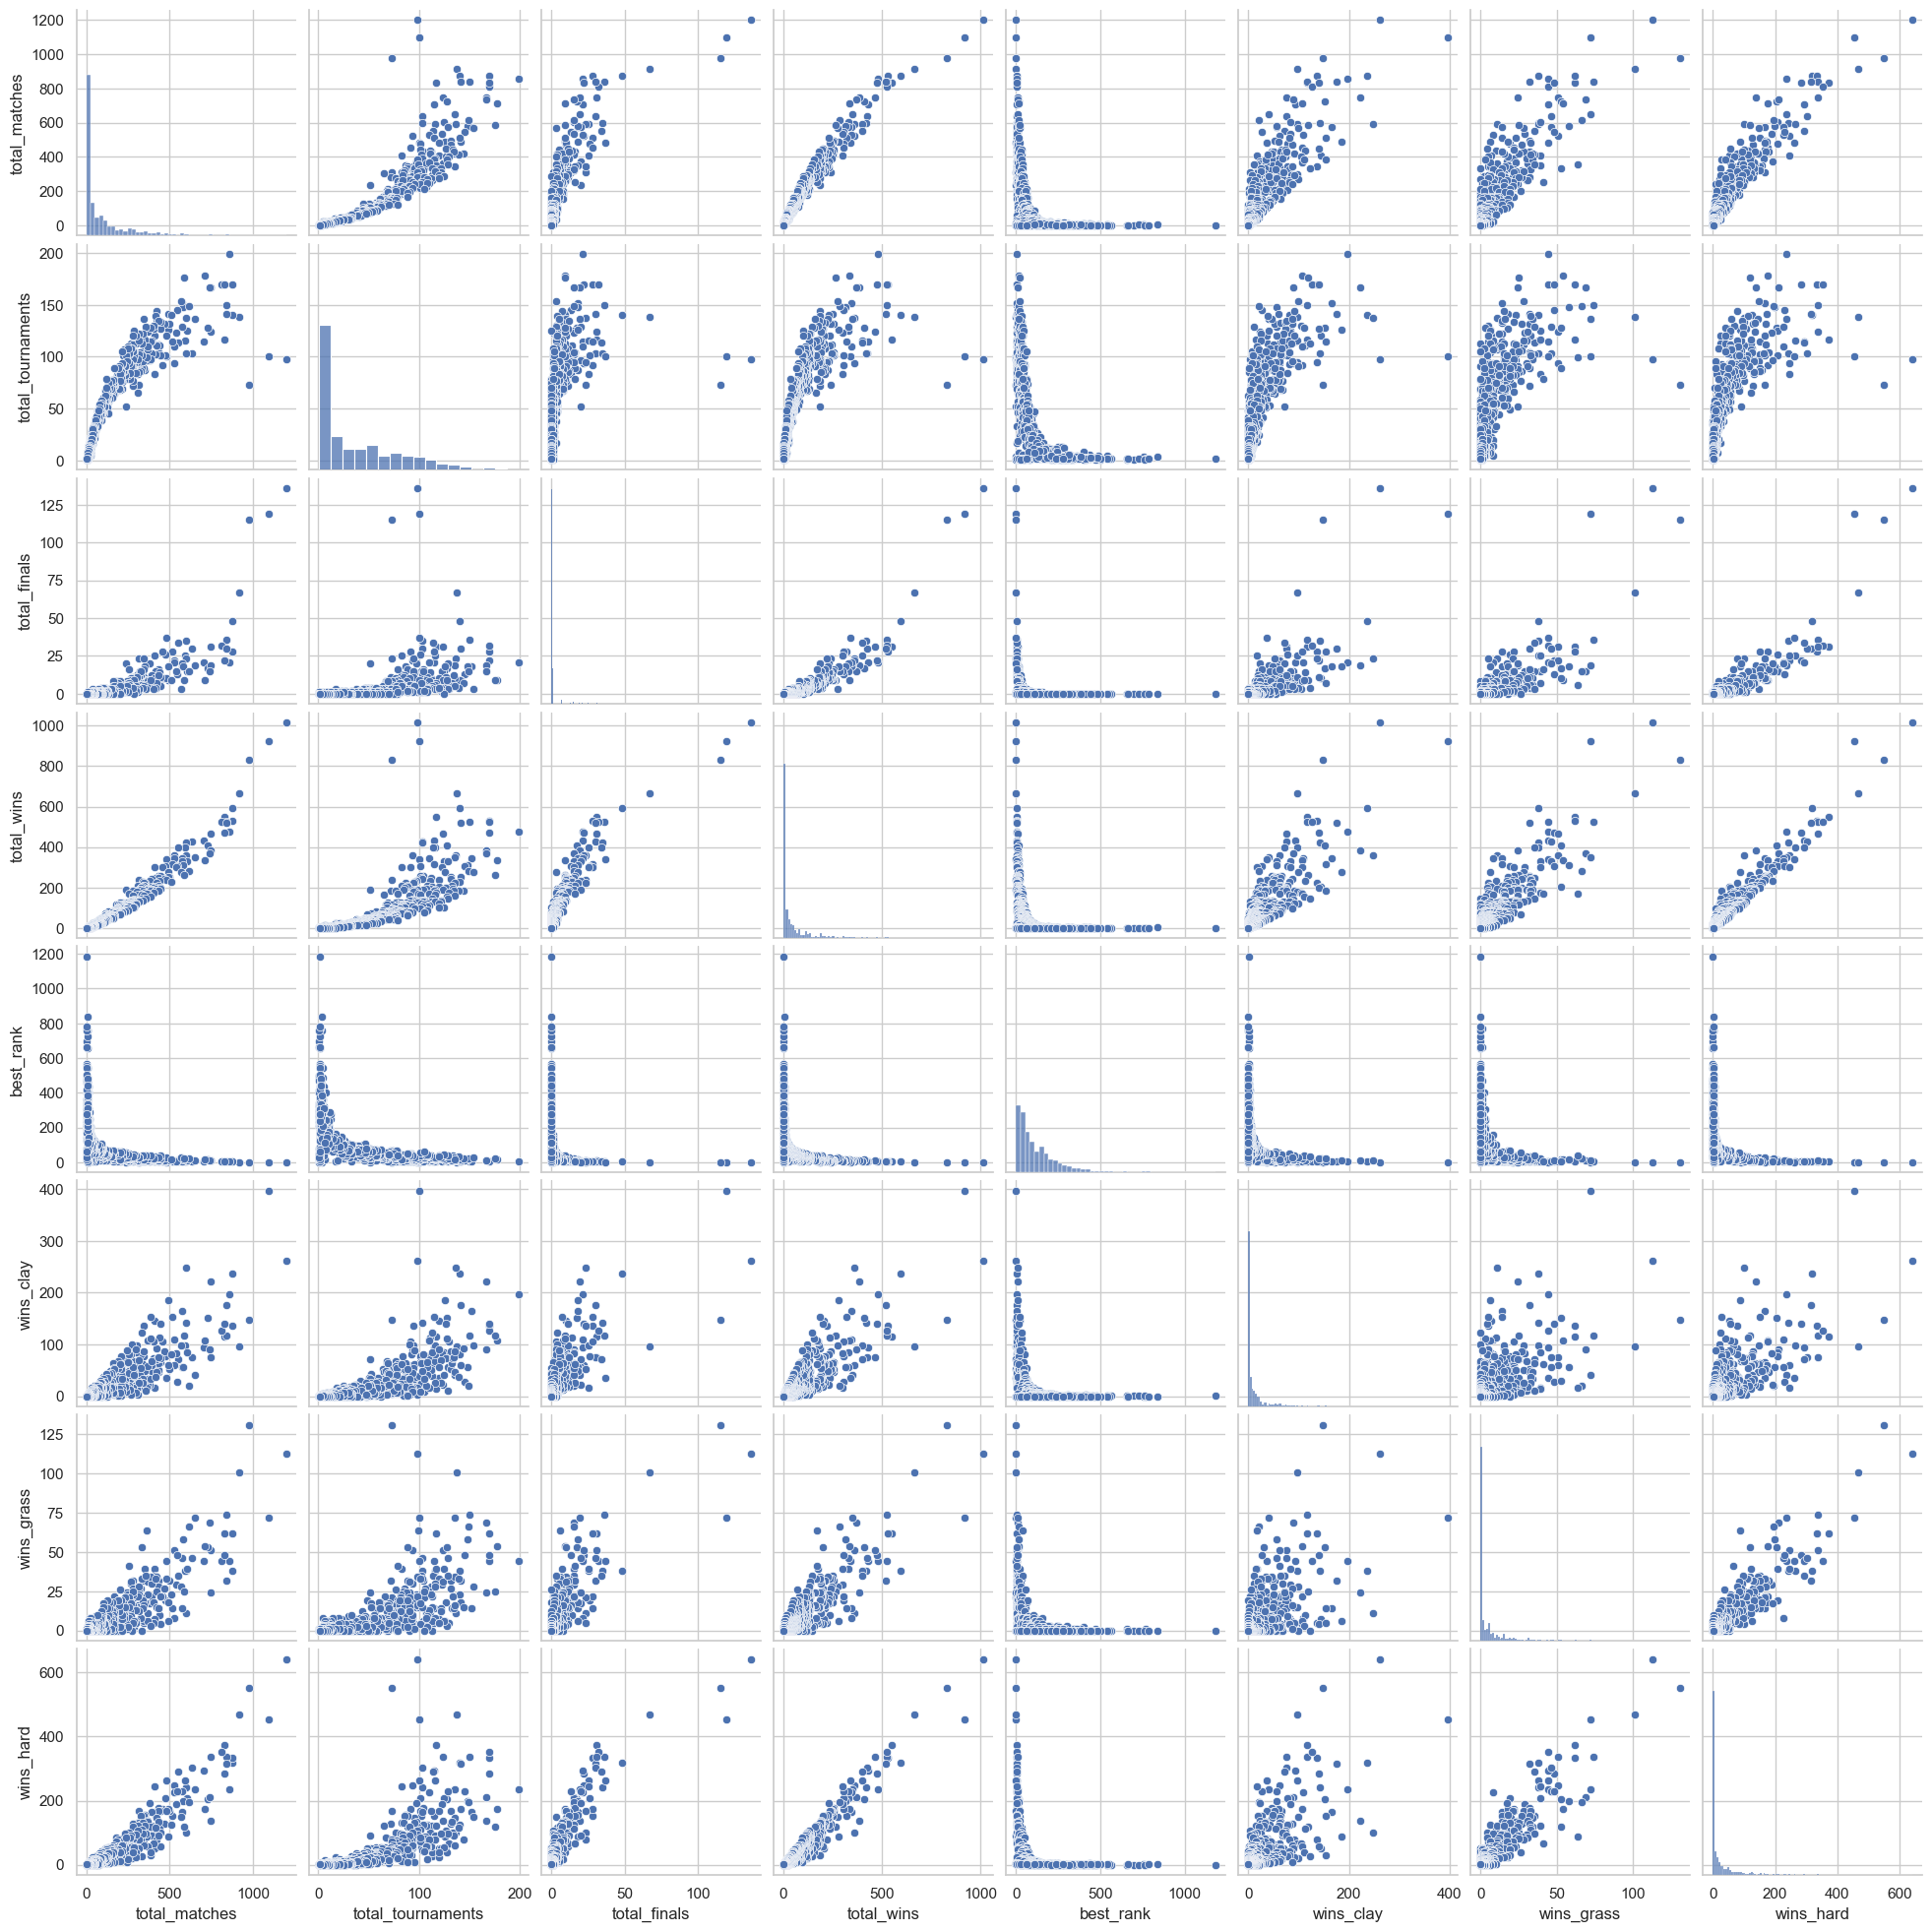

In [76]:
# sns.pairplot(): È una funzione di Seaborn che genera un pairplot, ovvero una matrice di grafici a dispersione tra tutte le coppie di colonne del DataFrame. 
# Inoltre, genera anche istogrammi lungo la diagonale per mostrare la distribuzione di ciascuna variabile.

sns.pairplot(vincitori)
plt.show()

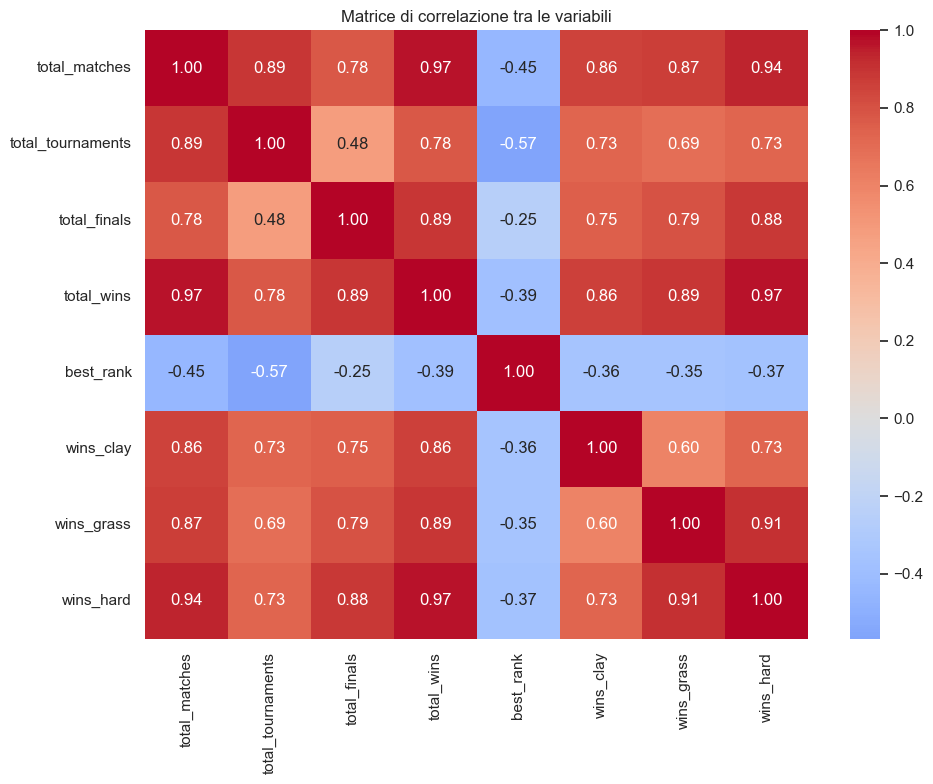

In [77]:
plt.figure(figsize=(10, 8))
correlation_matrix = vincitori.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Matrice di correlazione tra le variabili')
plt.tight_layout()
plt.show()

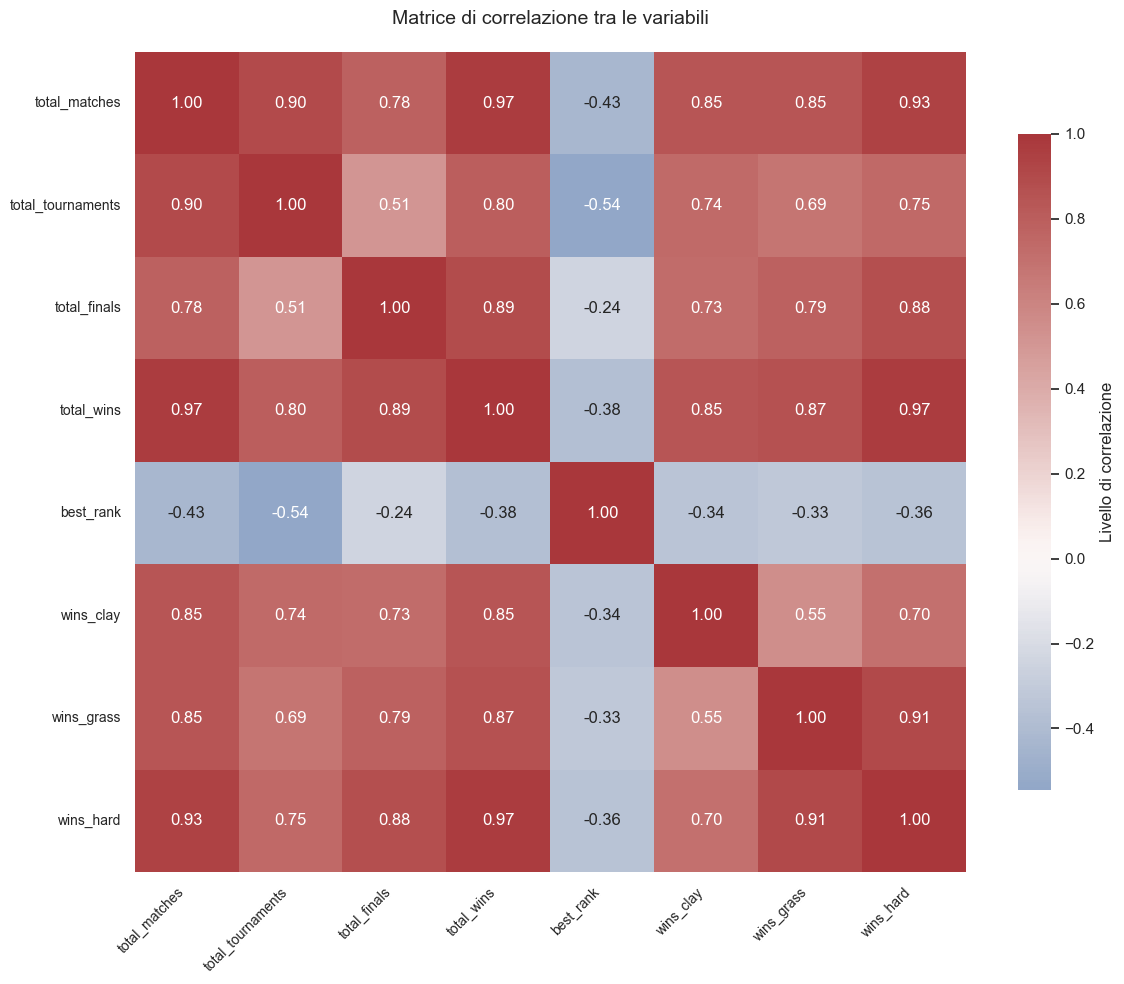

In [56]:
# Visualizzazione diversamente brutta

import matplotlib.pyplot as plt
import seaborn as sns

# Creazione della figura
plt.figure(figsize=(12, 10))

# Calcolo della matrice di correlazione
correlation_matrix = vincitori.select_dtypes(include=['float64', 'int64']).corr()

# Creazione della heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,            # Mostra i valori numerici
    cmap='vlag',           # Colormap con maggior contrasto
    fmt='.2f',             # Formato dei numeri (2 cifre decimali)
    center=0,              # Centra i colori intorno a 0
    cbar_kws={'shrink': 0.8, 'label': 'Livello di correlazione'}  # Personalizza la color bar
)

# Miglioramento dell'aspetto
plt.xticks(rotation=45, ha='right', fontsize=10)  # Ruota e ridimensiona i tick dell'asse X
plt.yticks(fontsize=10)                           # Ridimensiona i tick dell'asse Y
plt.title('Matrice di correlazione tra le variabili', fontsize=14, pad=20)  # Titolo con padding
plt.tight_layout()

# Mostra il grafico
plt.show()

La PCA (Principal Component Analysis) è una tecnica di riduzione della dimensionalità che consente di ridurre il numero di variabili, mantenendo la maggior parte dell’informazione (varianza) del dataset originale. PCA trova delle combinazioni lineari delle variabili originali chiamate componenti principali che spiegano la maggior parte della varianza nel dataset.

Quando hai un dataset con molte feature correlate, come nel tuo caso, la PCA ti permette di ridurre il numero di variabili senza perdere informazioni cruciali, migliorando l’efficienza computazionale e la comprensibilità del modello.

Passaggi per applicare PCA:

1.	Preparare i dati: È importante normalizzare i dati prima di applicare la PCA, poiché PCA è sensibile alla scala delle variabili.

2.	Applicare PCA: Usare PCA di Scikit-learn per ridurre il numero di componenti.

3.	Scegliere il numero di componenti: Decidere quante componenti principali mantenere. Generalmente si mantiene abbastanza componenti per spiegare una percentuale significativa della varianza (ad esempio, l’80% della varianza).

Codice per applicare la PCA:

1.	Normalizzazione dei Dati: Prima di applicare PCA, bisogna normalizzare i dati (ridurre i valori a una scala comune).

2.	Applicazione della PCA: Dopo aver normalizzato i dati, possiamo applicare la PCA e ridurre il numero di componenti.

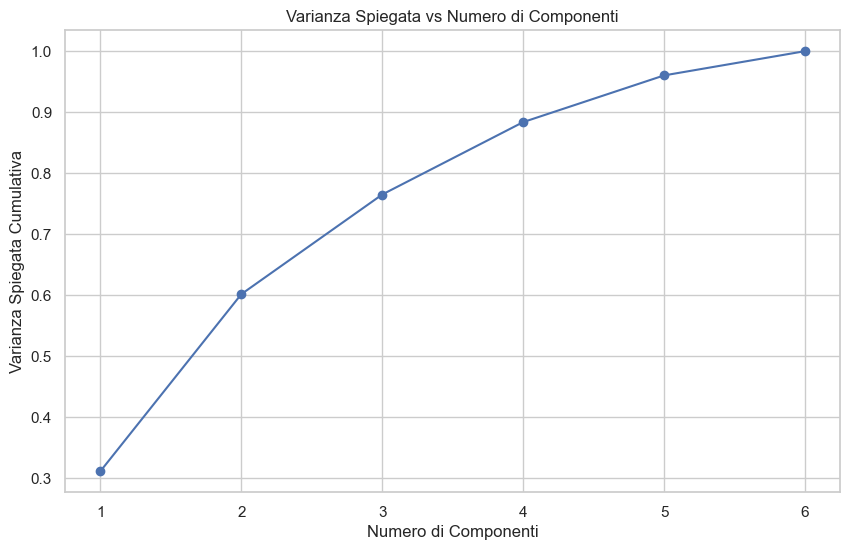


Varianza spiegata da ogni componente:
Componente 1: 0.312 (31.2%)
Componente 2: 0.290 (29.0%)
Componente 3: 0.163 (16.3%)
Componente 4: 0.119 (11.9%)
Componente 5: 0.077 (7.7%)
Componente 6: 0.040 (4.0%)

Matrice dei componenti principali:
       Rank_1    Rank_2     Pts_1     Pts_2     Odd_1     Odd_2
PC1 -0.328561  0.303090  0.376708 -0.344629 -0.511122  0.527504
PC2 -0.301807 -0.323670  0.547246  0.567622  0.317557  0.285717
PC3  0.583226  0.583516  0.126514  0.116342  0.379734  0.381597
PC4 -0.617862  0.633573 -0.249119  0.274991  0.186132 -0.210964
PC5 -0.265893 -0.230689 -0.419876 -0.414605  0.523833  0.503477
PC6 -0.091400  0.090832  0.551589 -0.545878  0.429729 -0.443277


In [61]:
# Preparazione dei dati per PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Selezione delle features numeriche per PCA
features_for_pca = ['Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2']
X = df[features_for_pca]

# Standardizzazione dei dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applicazione PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Visualizzazione della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata vs Numero di Componenti')
plt.grid(True)
plt.show()

# Stampa della varianza spiegata per ogni componente
print("\nVarianza spiegata da ogni componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.3f} ({var*100:.1f}%)")

# Matrice dei componenti
componenti_df = pd.DataFrame(
    pca.components_,
    columns=features_for_pca,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

print("\nMatrice dei componenti principali:")
print(componenti_df)